In [2]:
import datetime as dt
import os
import pickle
import re
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import osmnx as ox

In [3]:
# Minimal caching; use pickling for full caching
ox.config(use_cache=True)

In [4]:
# Parameters
resolution = 10  # number of degrees to round to
assert 180 % resolution == 0

use_pickle = True  # use cached bearings

# Top twelve cities by population [src: https://en.wikipedia.org/wiki/List_of_cities_in_the_United_Kingdom]
# Skipped any cities that did not have well-defined boundaries (check using next two cells)
cities = [
  'Birmingham', 'Leeds', 'Sheffield', 'Bradford', 'Manchester', 'Liverpool', 
  'Bristol', 'Wakefield', 'Coventry', 'Nottingham', 'Newcastle upon Tyne', 'Sunderland',
]

## Introduction

An aerial observer would be forgiven for mistaking Barcelona’s octagonal blocks and diagonal streets (shown above) as some red-brick reimagining of Legoland. Indeed, Spain’s 2000-year-old capital is a strict grid-like design, engineered to tackle overpopulation while maximizing airflow for its inhabitants. It’s an ancient city with all the efficiency of contemporary urban structures like New York.

Barcelona is a fascinating example, but its grid-like patterns are obvious to the human eye. I wondered about other cities with more complex features. What subtle quirks lie in the road/street structures of Bristol, Newcastle or Coventry?

For that question I wanted a scientific answer, so I set about applying data science to learn more about the intricacies of the UK’s densely populated cities.

### Methodology

This project was made possible by [OpenStreetMap](https://www.openstreetmap.org/) (OSM). OSM is a world-wide database of roads, trails and streets, verified by field maps and aerial imagery and  maintained by an active community of engineers and GIS professionals. Its open API enables raw geodata to be sourced on any city in the world.

OSM describes geodata elements in a number of ways. Linear features, like roads or rivers, are modelled using a “way”: nodes (between 2 and 2000) connected into a simple chain of line segments, a polyline. Most whole cities with solid polygon geometries (Manchester and Birmingham to name a few) are bounded by a single “closed way”, with the same start and end nodes. These are generally those with a well-defined natural border in the real world. Others, that have no obvious boundary, are rather represented as a single point marker, denoting the center of the city. We will be focusing on the former type as the more complex definition of the geometry allows us to draw far more insight.

Of the UK cities with these 'nice' geometries, the twelve with the largest populations were considered and OSM API was used to fetch full network graphs, from which the bearings of streets were determined. A summary of this data is shown below.

In [5]:
queries = {c: f"{c}, UK" for c in cities}

In [12]:
# Collect and check geometry/bounding boxes
geo = ox.gdf_from_places(queries.values())
display(geo)
assert geo.geometry.type.str.match("polygon", flags=re.IGNORECASE).all()

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((-2.03365 52.40231, -2.03322 52.40217...","Birmingham, West Midlands Combined Authority, ...",52.608706,52.381053,-1.728858,-2.033649
1,"POLYGON ((-1.80042 53.88595, -1.80041 53.88594...","Leeds, Yorkshire and the Humber, England, Unit...",53.945872,53.698968,-1.290352,-1.800421
2,"POLYGON ((-1.80147 53.48098, -1.80049 53.48027...","Sheffield, Yorkshire and the Humber, England, ...",53.503104,53.304512,-1.324669,-1.801471
3,"POLYGON ((-2.06125 53.82562, -2.06017 53.82504...","Bradford, Yorkshire and the Humber, England, U...",53.963151,53.724341,-1.640330,-2.061248
4,"POLYGON ((-2.31992 53.41161, -2.31847 53.40999...","Manchester, Greater Manchester, North West Eng...",53.544592,53.340104,-2.146829,-2.319918
5,"POLYGON ((-3.01917 53.43616, -3.01806 53.43323...","Liverpool, North West England, England, United...",53.474967,53.311543,-2.818000,-3.019173
6,"POLYGON ((-2.71837 51.50617, -2.71837 51.50616...","Bristol, City of Bristol, South West England, ...",51.544432,51.397284,-2.510419,-2.718370
7,"POLYGON ((-1.62490 53.65363, -1.62488 53.65358...","Wakefield, Yorkshire and the Humber, England, ...",53.741811,53.575349,-1.198814,-1.624898
8,"POLYGON ((-1.61446 52.42795, -1.61412 52.42774...","Coventry, West Midlands Combined Authority, We...",52.464772,52.363885,-1.423957,-1.614459
9,"POLYGON ((-1.24696 52.95344, -1.24689 52.95317...","City of Nottingham, East Midlands, England, Un...",53.018672,52.889008,-1.086119,-1.246956


## Visualizations

For each of these 12 cities, the returned bearings were weighted by street length to produce the following visualisations using simple polar projection plots. It is important to note two key points about this approach:
1. The bearings of streets were derived from only their start and finish nodes, ignoring paths in-between. This was to ensure reasonable computation times as an alternative to using the full polylines.
2. Naturally, bearings are rotationally symmetric as we do not account for the direction of one-way streets. 

In [15]:
# Collect bearings/load from cache
loaded_pickle = False
if use_pickle:
    if os.path.exists('bearing_cache.pkl'):
        with open('bearing_cache.pkl', 'rb') as f:
            bearings = pickle.load(f)
        loaded_pickle = True

if not loaded_pickle:
    # Warning: takes some time to run (~1-2 mins per city)
    bearings = {}
    for c, q in queries.items():
        print(f"[{dt.datetime.now().time()}] Collecting bearings for {c}")

        # Obtain road network graph
        G = ox.graph_from_place(q, network_type='drive')

        # Calculate edge bearings
        G = ox.add_edge_bearings(ox.get_undirected(G))

        # weight bearings by length
        weights = {b: 0 for b in range(0, 360, resolution)}
        for u, v, d in G.edges(data=True):
            if not (np.isnan(b := d['bearing']) or np.isnan(l := d['length'])):
                rounded_bearing = int(round(b / resolution) * resolution) % 180
                weights[rounded_bearing] = weights[rounded_bearing] + l
        bearings[c] = weights

    if use_pickle:
        with open('bearing_cache.pkl', 'wb') as f:
            pickle.dump(bearings, f)

In [16]:
# Mirror bearings
for city, weights in bearings.items():
    for bearing, weight in weights.items():
        if bearing >= 180:
            continue
        else:
            bearings[city][bearing + 180] = weight

In [51]:
def polar_plot(ax, city, weights):
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    
    x, y = zip(*weights.items())
    x = [e * math.pi / 180 for e in x]
    y = [e / sum(y) for e in y]
    
    bars = ax.bar(x, y, width=math.pi / 18,
                  color='#B2C4FF', edgecolor='#4C4948')
    ax.set_axisbelow(True)

    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['' for y in ax.get_yticks()]
    ax.set_yticklabels(labels=yticklabels)
    
    title_font = {'family':'DejaVu Sans', 'weight': 'bold', 'size':18, 'y': 1.12}
    ax.set_title(city.upper(), **title_font)
    
    xticklabels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    xtick_font = {'family':'Century Gothic', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

### Birmingham

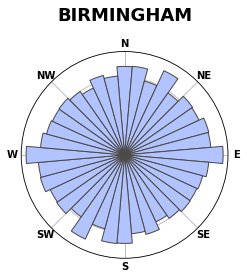

In [57]:
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': 'polar'})
polar_plot(ax, 'Birmingham', bearings['Birmingham'])
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')

Birmingham’s visualization is unmistakably circular. Many older cities lack a grid structure, with impromptu-built streets going off in many different directions. The place now called “Birmingham” has been around for more than 1,400 years. It was believed to have been established by a Saxon tribe, before expanding over the centuries into the city of 8500 streets we know today.


### Manchester & Newcastle

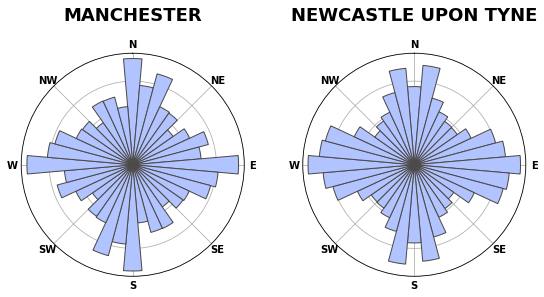

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection': 'polar'})
polar_plot(ax[0], 'Manchester', bearings['Manchester'])
polar_plot(ax[1], 'Newcastle upon Tyne', bearings['Newcastle upon Tyne'])
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')

Manchester displays quite a clear cross-like visualization. This city has an interesting grid structure with a strong emphasis on moving north-to-south. The east-to-west flow is perhaps due to Manchester sitting almost directly between Liverpool and Sheffield, and the reduced SE/NW activity might result from its position just in the upper left of the Peak District.

Newcastle is similar but for a more obvious reason; its central ring-road system, which is vaguely hexagonal, is presumably responsible for the high degree of symmetry we observe.

### Coventry

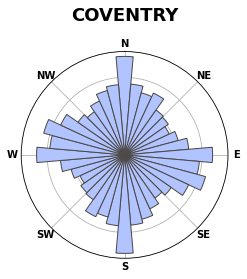

In [55]:
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': 'polar'})
polar_plot(ax, 'Coventry', bearings['Coventry'])
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')

Not unlike Manchester, Coventry’s visualization hints at a grid-like design. Famously, this ancient city—once a hotspot of trade for cloth and textiles—was obliterated in 1940 by a series of bombing raids, now called the Coventry Blitz. In the decades following, the city’s remains were rebuilt into a modern grid structure.

### Bristol

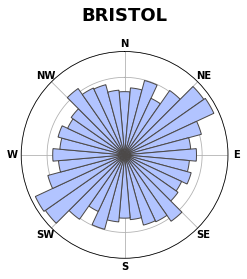

In [54]:
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': 'polar'})
polar_plot(ax, 'Bristol', bearings['Bristol'])
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')

For a city founded on the turn of the second-last millennia, we wouldn’t expect to see much beyond a uniformly distributed set of bearings. Yet Bristol’s otherwise almost-circular plot is cut along the NE/SW line. Modern Bristol is dominated by the M5, as well as the River Avon. It’s interesting that a 1960s motorway construction can have such an impact on the bearings of an ancient city.

## Final Thoughts

As well as analyzing the street orientations of individual cities, it is beneficial to to showcase their visualizations side-by-side to draw comparisons and appreciate relative differences. To extend, I have collated the visualizations for the twelve cities I considered into one final image.

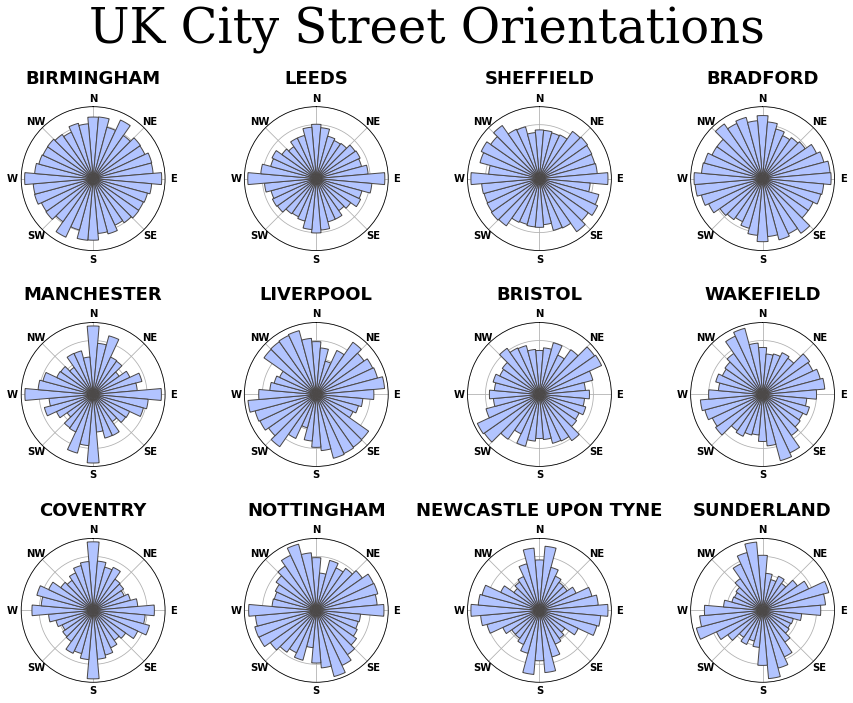

In [53]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9), subplot_kw={'projection': 'polar'})
for i, (city, weights) in enumerate(bearings.items()):
    polar_plot(axs[i // 4][i % 4], city, weights)
suptitle_font = {'family': 'DejaVu Serif', 'fontsize':48, 'y': 1.08}
fig.suptitle('UK City Street Orientations', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')

### The Importance of Data Science

I think it important to observe how data science, once a niche and theoretical discipline, can offer such rich insights into the history of the UK’s major cities. From Birmingham’s pre-industrial beginnings, to the devastating campaigns of the German Luftwaffe, these simple visualisations tell stories of our past. They compress a millennia-long archive of the achievements and failures that gave rise to modern Britain.

To that extent, if you are a data scientist wondering how you can apply your technical skills to real-world projects, or a student with domain expertise, keen to build up the technical skills to answer the questions you care about, make sure you follow Warwick Data Science Society [on social media](https://www.facebook.com/warwickdatascience) to keep up-to-date with relevant opportunties. These include academic talks, data science news, workshops, and beginners programming courses, so there is certainly something for everyone. Thank you for reading this piece.